## Supervised Learning: Logistic Regression

----------
#### IMPORTS

##### Module Install Notice!
You'll need to install a new module we haven't used before: [Statsmodels](http://statsmodels.sourceforge.net/), and patsy.

You can install it with 'pip install statsmodels patsy' if you are using pip. 


In [1]:
# Data Imports
import numpy as np
import pandas as pd
from pandas import Series,DataFrame

# Math
import math

# Plot imports
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# Machine Learning Imports
from sklearn.linear_model import LogisticRegression
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split

# For evaluating our ML results
from sklearn import metrics

# Dataset Import
#python -m pip install statsmodels
import statsmodels.api as sm

### Basic Mathematical Overview

First, let's take a look at the [Logistic Function](http://en.wikipedia.org/wiki/Logistic_function). The logistic function can take an input from negative to positive infinity and it has always has an output between 0 and 1. The logistic function is defined as:
$$ p(f)= \frac{1}{1+e^{-f}}$$

A graph of the logistic function looks like this (following code):

Text(0.5,1,' Logistic Function ')

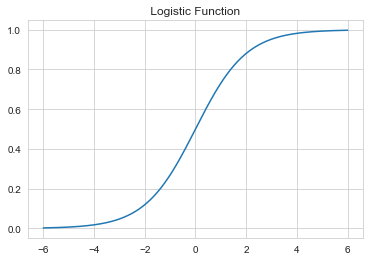

In [2]:
# Logistic Function
def logistic(f):
    return 1.0 / (1 + math.exp((-1.0)*f) )

# Set f from -6 to 6 ( 500 elements, linearly spaced)
f = np.linspace(-6,6,500)

# Set up y values (using list comprehension)
y = np.array([logistic(ele) for ele in f])

# Plot
plt.plot(f,y)
plt.title(' Logistic Function ')


If we remember back to the Linear Regression Lectures, we could describe a [Linear Regression](http://en.wikipedia.org/wiki/Linear_regression) Function model as:
$$ y_i = w_1 x_{i1} + ... +  w_i x_{ip}$$

Which was basically an expanded linear equation (y=mx+b) for various x data features. In the case of the above equation, we presume a data set of 'n' number of units, so that the data set would have the form:
$$ [ y_i, x_{i1},...,x_{ip}]^{n}_{i=1}$$

For our logistic function, if we view *t* as a linear function with a variable *x* we could express t as:
$$ f = w_0 + w_1 x $$

Here, we've basically just substituted a linear function (form similar to y=mx+b) for f. We could then rewrite our logistic function equation as:
$$ p(x)= \frac{1}{1+e^{-(w_0 + w_1 x)}}$$

Now we can interpret p(x) as the probability that the dependent variable is a "success" case, this is a similar style of thinking as in the Binomial Distribution, in which we had successes and failures. So the formula for p(x) that we have here states that the probability of the dependent variable equaling a "success" case is equal to the value of the logistic function of the linear regression expression (the linear equation we used to replace *f* ).

Inputting the linear regression expression into the logistic function allows us to have a linear regression expression value that can vary from positive to negative infinity, but after the transformation due to the logistic expression we will have an output of p(x) that ranges from 0 to 1.

We can now perform a binary classification based on where p(x) lies, either from 0 to 0.5, or 0.5 to 1. 

-----------
### Dataset Analysis
Let us go ahead and take a look at the [dataset](http://statsmodels.sourceforge.net/stable/datasets/generated/fair.html)

The dataset is packaged within Statsmodels. It is a data set from a 1974 survey of women by Redbook magazine. Married women were asked if they have had extramarital affairs. The published work on the data set can be found in:

[Fair, Ray. 1978. “A Theory of Extramarital Affairs,” `Journal of Political Economy`, February, 45-61.](http://fairmodel.econ.yale.edu/rayfair/pdf/1978a200.pdf)

It is important to note that this data comes from a self-reported survey, which can have many issues as far as the accuracy of the data. Also this analysis isn't trying to promote any agenda concerning women or marriage, the data is just interesting but its accuracy should be met with a healthy dose of skepticism.

We'll ignore those issues concerning the data and just worry about the logistic regression aspects to the data.

In this case we will approach this as a classification problem by asking the question:

*Given certain variables for each woman, can we classify them as either having particpated in an affair, or not participated in an affair?*


#### DataSet Description

From the [Statsmodels website](http://statsmodels.sourceforge.net/stable/datasets/generated/fair.html) we have the following information about the data:

Number of observations: 6366
Number of variables: 9
Variable name definitions:

    rate_marriage   : How rate marriage, 1 = very poor, 2 = poor, 3 = fair,
                    4 = good, 5 = very good
    age             : Age
    yrs_married     : No. years married. Interval approximations. See
                    original paper for detailed explanation.
    children        : No. children
    religious       : How relgious, 1 = not, 2 = mildly, 3 = fairly,
                    4 = strongly
    educ            : Level of education, 9 = grade school, 12 = high
                    school, 14 = some college, 16 = college graduate,
                    17 = some graduate school, 20 = advanced degree
    occupation      : 1 = student, 2 = farming, agriculture; semi-skilled,
                    or unskilled worker; 3 = white-colloar; 4 = teacher
                    counselor social worker, nurse; artist, writers;
                    technician, skilled worker, 5 = managerial,
                    administrative, business, 6 = professional with
                    advanced degree
    occupation_husb : Husband's occupation. Same as occupation.
    affairs         : measure of time spent in extramarital affairs

See the original paper for more details.

------------
### Data Visualization
We will start with loading the data and visualizing it. 

In [3]:
# Standard method of loading Statsmodels datasets into a pandas DataFrame. Note the name fair stands for 'affair' dataset.
df = sm.datasets.fair.load_pandas().data

In [4]:
# Preview
df.head()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs
0,3.0,32.0,9.0,3.0,3.0,17.0,2.0,5.0,0.111111
1,3.0,27.0,13.0,3.0,1.0,14.0,3.0,4.0,3.230769
2,4.0,22.0,2.5,0.0,1.0,16.0,3.0,5.0,1.400000
3,4.0,37.0,16.5,4.0,3.0,16.0,5.0,5.0,0.727273
4,5.0,27.0,9.0,1.0,1.0,14.0,3.0,4.0,4.666666


Great! Let's go ahead and start our classfication by creating a new column called 'Had_Affair'. We will set this column equal to 0 if the affairs column is 0 (meaning no time spent in affairs) otherwise the 'Had_Affair' value will be set as 1, indicating that the woman had an affair.

In [5]:
# Create check function
def affair_check(x):
    if x != 0:
        return 1
    else:
        return 0

# Apply to DataFrame
df['Had_Affair'] = df['affairs'].apply(affair_check)

Let's go ahead and see the result!

In [6]:
# DataFrame Check
df

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs,Had_Affair
0,3.0,32.0,9.0,3.0,3.0,17.0,2.0,5.0,0.111111,1
1,3.0,27.0,13.0,3.0,1.0,14.0,3.0,4.0,3.230769,1
2,4.0,22.0,2.5,0.0,1.0,16.0,3.0,5.0,1.400000,1
3,4.0,37.0,16.5,4.0,3.0,16.0,5.0,5.0,0.727273,1
4,5.0,27.0,9.0,1.0,1.0,14.0,3.0,4.0,4.666666,1
5,4.0,27.0,9.0,0.0,2.0,14.0,3.0,4.0,4.666666,1
6,5.0,37.0,23.0,5.5,2.0,12.0,5.0,4.0,0.852174,1
7,5.0,37.0,23.0,5.5,2.0,12.0,2.0,3.0,1.826086,1
8,3.0,22.0,2.5,0.0,2.0,12.0,3.0,3.0,4.799999,1
9,3.0,27.0,6.0,0.0,1.0,16.0,3.0,5.0,1.333333,1


Now let's go ahead and groupby the newly created 'Had_Affair' column. We'll do this by grouping by the column and then calling the mean aggregate function. 

In [7]:
# Groupby Had Affair column
df.groupby('Had_Affair').mean()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs
Had_Affair,,,,,,,,,
0,4.329701,28.390679,7.989335,1.238813,2.504521,14.322977,3.405286,3.833758,0.000000
1,3.647345,30.537019,11.152460,1.728933,2.261568,13.972236,3.463712,3.884559,2.187243


Looking at this brief glance of the data, it seems that the women who had affairs were slightly older,married longer, and slightly less religious and less educated. However, the mean values of both classes are very close for all variables.

Let's go ahead and try to visualize some of this data.

First some histograms.

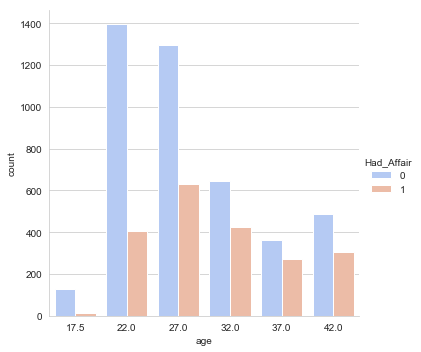

In [8]:
# Factorplot for age with Had Affair hue
#sns.factorplot(x='age',data=df,hue='Had_Affair',palette='coolwarm', kind='count')
sns.catplot(x='age',data=df,hue='Had_Affair',palette='coolwarm', kind='count')

This suggests a higher probability of an affair as age increases. Let's check the number of years married.

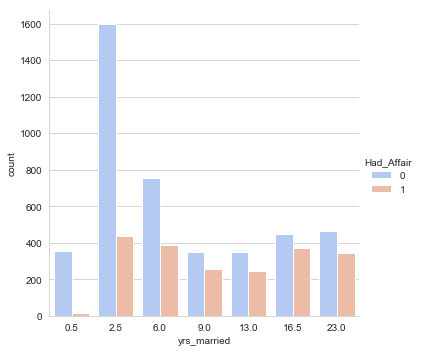

In [9]:
# Factorplot for years married with Had Affair hue
#sns.factorplot('yrs_married',data=df,hue='Had_Affair',palette='coolwarm', kind='count')
sns.catplot('yrs_married',data=df,hue='Had_Affair',palette='coolwarm', kind='count')

Looks like probability of having an affair increases with the number of years married. Let's check the number of children.

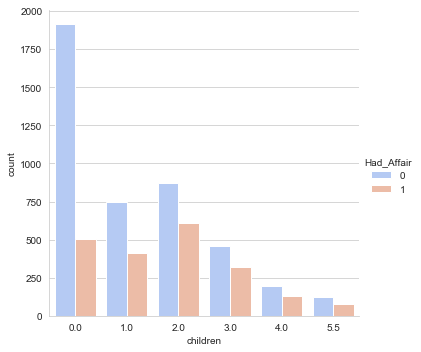

In [10]:
# Factorplot for number of children with Had Affair hue
#sns.factorplot('children',data=df,hue='Had_Affair',palette='coolwarm', kind='count')
sns.catplot('children',data=df,hue='Had_Affair',palette='coolwarm', kind='count')

Pretty strong evidence suggesting that less children results in a lower probability of an affair. Finally let's check the education level.

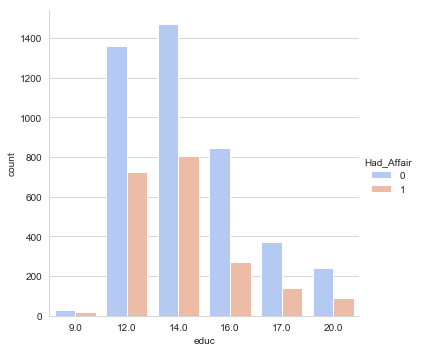

In [11]:
# Factorplot for number of children with Had Affair hue
#sns.factorplot('educ',data=df,hue='Had_Affair',palette='coolwarm', kind='count')
sns.catplot('educ',data=df,hue='Had_Affair',palette='coolwarm', kind='count')

Interesting! Go ahead and finish the remaining columns if you wish. For now, we will go ahead and begin diving into the Logistic Regression Analysis.

###  Data Preparation

If we look at the data, we'll notice that two columns are unlike the others. Occupation and Husband's Occupation. These columns are in a format know as *Categorical Variables*. Basically they are in set quantity/category, so that 1.0 and 2.0 are seperate variables, not values along a spectrum that goes from 1-2 (e.g. There is no 1.5 for the occupation column). Pandas has a built-in method of getting [dummy variables](http://en.wikipedia.org/wiki/Dummy_variable_%28statistics%29) and creating new columns from them.

In [12]:
# Create new DataFrames for the Categorical Variables
occ_dummies = pd.get_dummies(df['occupation'])
hus_occ_dummies = pd.get_dummies(df['occupation_husb'])

# Let's take a quick look at the results
occ_dummies.head()

,1.0,2.0,3.0,4.0,5.0,6.0
0,0,1,0,0,0,0
1,0,0,1,0,0,0
2,0,0,1,0,0,0
3,0,0,0,0,1,0
4,0,0,1,0,0,0


Great! Now let's name the columns something a little more readable.

In [13]:
# Create column names for the new DataFrames
occ_dummies.columns = ['occ1','occ2','occ3','occ4','occ5','occ6']
hus_occ_dummies.columns = ['hocc1','hocc2','hocc3','hocc4','hocc5','hocc6']

Now we will create the X and Y data sets for out logistic regression!

In [14]:
# Set X as new DataFrame without the occupation columns or the Y target
X = df.drop(['occupation','occupation_husb','Had_Affair'],axis=1)

In [15]:
# Concat the dummy DataFrames Together
dummies = pd.concat([occ_dummies,hus_occ_dummies],axis=1)

Now we will concatenate all the DataFrames together.

In [16]:
# Now Concat the X DataFrame with the dummy variables
X = pd.concat([X,dummies],axis=1)

# Preview of Result
X.head()

,rate_marriage,age,yrs_married,children,religious,educ,affairs,occ1,occ2,occ3,occ4,occ5,occ6,hocc1,hocc2,hocc3,hocc4,hocc5,hocc6
0,3.0,32.0,9.0,3.0,3.0,17.0,0.111111,0,1,0,0,0,0,0,0,0,0,1,0
1,3.0,27.0,13.0,3.0,1.0,14.0,3.230769,0,0,1,0,0,0,0,0,0,1,0,0
2,4.0,22.0,2.5,0.0,1.0,16.0,1.400000,0,0,1,0,0,0,0,0,0,0,1,0
3,4.0,37.0,16.5,4.0,3.0,16.0,0.727273,0,0,0,0,1,0,0,0,0,0,1,0
4,5.0,27.0,9.0,1.0,1.0,14.0,4.666666,0,0,1,0,0,0,0,0,0,1,0,0


Now let's go ahead and set up the Y.

In [17]:
# Set Y as Target class, Had Affair
Y = df.Had_Affair

# Preview
Y.head()

0    1
1    1
2    1
3    1
4    1
Name: Had_Affair, dtype: int64

### Multicollinearity Consideration.

Now we need to get rid of a few columns. We will be dropping the occ1 and hocc1 columns to avoid [multicollinearity](http://en.wikipedia.org/wiki/Multicollinearity#Remedies_for_multicollinearity). Multicollinearity occurs due to the [dummy variables](http://en.wikipedia.org/wiki/Dummy_variable_(statistics)) we created. This is because the dummy variables are highly correlated, our model begins to get distorted because one of the dummy variables can be linearly predicted from the others. We take care of this problem by dropping one of the dummy variables from each set, we do this at the cost of losing a data set point.

The other column we will drop is the affairs column. This is because it is basically a repeat of what will be our Y target, instead of 0 and 1 it just has 0 or a number, so we'll need to drop it for our target to make sense.

In [18]:
# Dropping one column of each dummy variable set to avoid multicollinearity
X = X.drop('occ1',axis=1)
X = X.drop('hocc1',axis=1)

# Drop affairs column so Y target makes sense
X = X.drop('affairs',axis=1)

# PReview
X.head()

,rate_marriage,age,yrs_married,children,religious,educ,occ2,occ3,occ4,occ5,occ6,hocc2,hocc3,hocc4,hocc5,hocc6
0,3.0,32.0,9.0,3.0,3.0,17.0,1,0,0,0,0,0,0,0,1,0
1,3.0,27.0,13.0,3.0,1.0,14.0,0,1,0,0,0,0,0,1,0,0
2,4.0,22.0,2.5,0.0,1.0,16.0,0,1,0,0,0,0,0,0,1,0
3,4.0,37.0,16.5,4.0,3.0,16.0,0,0,0,1,0,0,0,0,1,0
4,5.0,27.0,9.0,1.0,1.0,14.0,0,1,0,0,0,0,0,1,0,0


In order to use the Y with SciKit Learn, we need to set it as a 1-D array. This means we need to "flatten" the array. Numpy has a built in method for this called [ravel](http://docs.scipy.org/doc/numpy/reference/generated/numpy.ravel.html). Let's use it!

In [19]:
# Flatten array
Y = np.ravel(Y)

# Check result
Y

array([1, 1, 1, ..., 0, 0, 0])

### Logistic Regression with SciKit Learn

Finally! Now let's go ahead and run the logistic regression. This is a very similar process to the Linear Regression from the previous lecture. We'll create the model, the fit the data into the model, and check our accuracy score. Then we'll split the data into testing and training sets and see if our results improve.

Let's start by initiating the model!

In [20]:
# Create LogisticRegression model
#log_model = LogisticRegression()
log_model = LogisticRegression()

# Fit our data
log_model.fit(X,Y)

# Check our accuracy
log_model.score(X,Y)

/Users/lei/projects/env/lib/python2.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.7258875274897895

Looks like we got a 73% accuracy rating. Let's go ahead and compare this to the original Y data. We can do this by simply taking the mean of the Y data, since it is in the format 1 or 0, we can use the mean to calulate the percentage of women who reported having affairs. This is known as checking the [null error rate](http://en.wikipedia.org/wiki/Type_I_and_type_II_errors).

In [ ]:
# Check percentage of women that had affairs
Y.mean()

This means that if our model just simply guessed "no affair" we would have had 1-0.32=0.68 accuracy (or 68%) accuracy. So while we are doing better than the null error rate, we aren't doing that much better.

Let's go ahead and check the coefficients of our model to check what seemed to be the stronger predictors.

In [ ]:
# Use zip to bring the column names and the np.transpose function to bring together the coefficients from the model
coeff_df = DataFrame(zip(X.columns, np.transpose(log_model.coef_)))

Looking at the coefficients we can see that a positive coeffecient corresponds to increasing the likelihood of having an affair while a negative coefficient means it corresponds to a decreased likelihood of having an affair as the actual data value point increases.

As you might expect, an increased marriage rating corresponded to a decrease in the likelihood of having an affair. Increased religiousness also seems to correspond to a decrease in the likelihood of having an affair. 

Since all the dummy variables (the wife and husband occupations) are positive that means the lowest likelihood of having an affair corresponds to the baseline occupation we dropped (1-Student).

### Part 8: Testing and Training Data Sets

Just like we did in the Linear Regression Lab, we should be splitting our data into training and testing data sets. We'll follow a very similar procedure to the Linear Regression Lecture by using SciKit Learn's built-in train_test_split method.

In [ ]:
# Split the data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y)

# Make a new log_model
log_model2 = LogisticRegression()

# Now fit the new model
log_model2.fit(X_train, Y_train)

Now we can use predict to predict classification labels for the next test set, then we will reevaluate our accuracy score!

In [ ]:
# Predict the classes of the testing data set
class_predict = log_model2.predict(X_test)

# Compare the predicted classes to the actual test classes
print metrics.accuracy_score(Y_test,class_predict)

Now we have a 73.35% accuracy score, which is basically the same as our previous accuracy score, 72.58%.

### Conclusion and more Resources

So what could we do to try to further improve our Logistic Regression model? We could try some [regularization techniques](http://en.wikipedia.org/wiki/Regularization_%28mathematics%29#Regularization_in_statistics_and_machine_learning) or using a non-linear model.